In [413]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [432]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import string
from collections import OrderedDict
from sklearn.feature_extraction import FeatureHasher
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [415]:
data = pd.read_pickle('/content/drive/My Drive/Applied_AI_Workshop_Code_Data/pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


**IDF based product similarity**

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#if you do NOT have RAM >= 12GB, use the code below.
with open('/content/drive/My Drive/Applied_AI_Workshop_Code_Data/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [0]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)


In [0]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [0]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [0]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [0]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)
for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [0]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands).tocsr()

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors).tocsr()


In [0]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('/content/drive/My Drive/Applied_AI_Workshop_Code_Data/16k_data_cnn_features.npy') 

In [0]:
# Final model
def idf_w2v_one_hot_encoding_cnn_model(doc_id, result_count, wT, wB, wC, wI):
    # doc_id: apparel's id in given corpus
    # result_count: Number of results to show
    # wT: weight for  title features
    # wB: weight for brand
    # wC: weight for color features
    # wI: weight for image features
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels for title feature    
    title_distance = pairwise_distances(w2v_title_weight,w2v_title_weight[doc_id].reshape(1,-1))
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels for brand feature
    brand_distance = pairwise_distances(brand_features,brand_features[doc_id])
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels for color feature
    color_distance = pairwise_distances(color_features,color_features[doc_id])
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels for image feature
    image_distance = pairwise_distances(bottleneck_features_train,bottleneck_features_train[doc_id].reshape(1,-1))
    
    # Weighted pairwise distance for all feature.
    weighted_pairwise_dist = (wT * title_distance + wB * brand_distance + wC * color_distance + wI * image_distance)/float(wT + wB + wC + wI)
    
    # Nearest indices of datapoints with respective to input doc_id
    nearest_indices = np.argsort(weighted_pairwise_dist.flatten())[0:result_count]
    
    # Nearest distance values of datapoints with respective to input doc_id
    nearest_distances = np.sort(weighted_pairwise_dist.flatten())[0:result_count]
        
    # List of nearest data points
    list_nearest_data_points = list(data.index[nearest_indices])    
    
        
    # Just to print the output
    for i in range(0,len(nearest_indices)):
        display(Image(url=data['medium_image_url'].loc[list_nearest_data_points[i]], embed=True))
        print('ASIN : ',data['asin'].loc[list_nearest_data_points[i]])
        print('TITLE : ',data['title'].loc[list_nearest_data_points[i]])
        print('BRAND : ',data['brand'].loc[list_nearest_data_points[i]])
        print('COLOR : ',data['color'].loc[list_nearest_data_points[i]])
        print('Euclidean Distance from input is  :',nearest_distances[i])
        print('='*125)

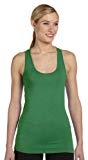

ASIN :  B0023UNW7I
TITLE :  alo sport ladies bamboo racerback tank w2006leafslatexl 
BRAND :  ALO
COLOR :  Leaf/Slate
Euclidean Distance from input is  : 7.822560363303066e-08


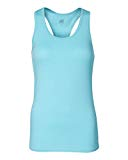

ASIN :  B003IWQKB0
TITLE :  alo sport ladies bamboo racerback tank aquawhite 
BRAND :  ALO
COLOR :  Aqua/White
Euclidean Distance from input is  : 0.6119416928758808


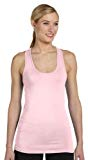

ASIN :  B004J8LKP8
TITLE :  alo sport ladies bamboo racerback tank  pinkwhite  xs 
BRAND :  ALO
COLOR :  Pink/White
Euclidean Distance from input is  : 0.9303522296980316


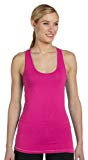

ASIN :  B003IWOLYS
TITLE :  alo sport  ladies racerback bamboo tank 
BRAND :  ALO
COLOR :  Berry/White
Euclidean Distance from input is  : 1.1302008161357804


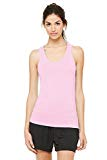

ASIN :  B0745GGJSB
TITLE :  alo sport ladies bamboo racerback tank small pinkwhite 
BRAND :  ALO Sport
COLOR :  Pink/White
Euclidean Distance from input is  : 1.4805968415503408


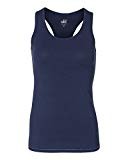

ASIN :  B004J8K1J4
TITLE :  alo sport ladies bamboo racerback tank xl dk navypacific 
BRAND :  ALO
COLOR :  Blue
Euclidean Distance from input is  : 1.793949079584583


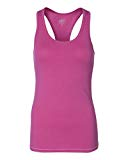

ASIN :  B003IWNDII
TITLE :  alo ladies racerback bamboo tank 
BRAND :  ALO
COLOR :  Berry/White
Euclidean Distance from input is  : 1.9153391520182292


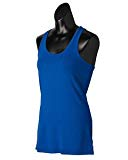

ASIN :  B003IWUMO6
TITLE :  alo lad racerback bamboo tank royaldark navy xs 
BRAND :  ALO
COLOR :  Royal/Navy
Euclidean Distance from input is  : 2.3152949389289406


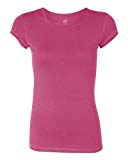

ASIN :  B004J8K0E0
TITLE :  alo  ladies short sleeve bamboo tshirt  w1004  berrywhite  large 
BRAND :  ALO Sport
COLOR :  BERRY/WHITE
Euclidean Distance from input is  : 2.551086986766142


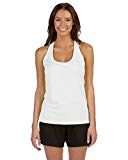

ASIN :  B00L8ASCKQ
TITLE :  alo sport womens performance racerback tank white 
BRAND :  ALO Sport
COLOR :  White
Euclidean Distance from input is  : 2.794161879853616


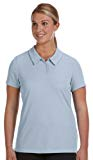

ASIN :  B00IM7XQ40
TITLE :  alo sport womens 3button mesh polo shirt sport crlna blue medium 
BRAND :  ALO Sport
COLOR :  Blue
Euclidean Distance from input is  : 2.9513992132635427


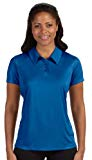

ASIN :  B01GESYBOM
TITLE :  alo ladies performance threebutton polo shirt  sport royal medium 
BRAND :  ALO Sport
COLOR :  Sport Royal
Euclidean Distance from input is  : 3.122586867388557


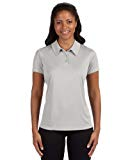

ASIN :  B01GESX27O
TITLE :  alo ladies performance threebutton polo shirt sport silver xlarge 
BRAND :  ALO Sport
COLOR :  Sport Silver
Euclidean Distance from input is  : 3.1281215069340726


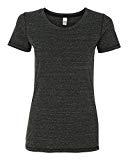

ASIN :  B00CQH2AT4
TITLE :  alo sport ladies performance triblend shortsleeve tshirt  chrcl hthr trblnd  
BRAND :  ALO Sport
COLOR :  Charcoal Heather Triblend
Euclidean Distance from input is  : 3.140701847596026


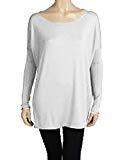

ASIN :  B00WL1CWWU
TITLE :  piko womens famous long sleeve bamboo top loose fit dolman style 
BRAND :  Piko
COLOR :  White
Euclidean Distance from input is  : 3.2319584914426605


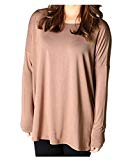

ASIN :  B019L076OW
TITLE :  piko womens famous long sleeve bamboo top loose fit large mocha 
BRAND :  Piko
COLOR :  Mocha
Euclidean Distance from input is  : 3.2644339068407535


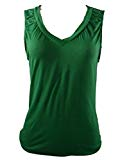

ASIN :  B00KY54BQK
TITLE :  armani collezioni bamboo jersey tank top blouse 8 green 
BRAND :  Armani Collezioni
COLOR :  Green
Euclidean Distance from input is  : 3.281685626155858


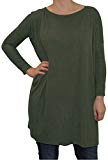

ASIN :  B011JA2FGG
TITLE :  piko womens famous long sleeve bamboo top loose fit dolman style large army 
BRAND :  Piko
COLOR :  Army Green
Euclidean Distance from input is  : 3.298038856833089


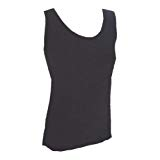

ASIN :  B00JV4OXJU
TITLE :  marrikas viscose bamboo scoop neck tank top black medium 1012 
BRAND :  Marrikas
COLOR :  Black
Euclidean Distance from input is  : 3.300382716296176


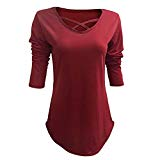

ASIN :  B0711KH9DX
TITLE :  hn long sleeve shirts women casual blouse top floral xl red 
BRAND :  H&N
COLOR :  Red
Euclidean Distance from input is  : 3.3015184861313815


In [445]:
idf_w2v_one_hot_encoding_cnn_model(500,20,50,50,1,1)